<a href="https://colab.research.google.com/github/GarryNeKasparov/Digit-Recognizer/blob/main/Square.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import PIL

In [ ]:
batch_size = 32
random_seed = 1

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),])

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

from torchvision.datasets import MNIST

train_data = MNIST(root = './', train=True, download=True, transform=transform)
val_data = MNIST(root = './', train=False, download=True, transform=transform)

--2021-03-22 18:24:59--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-22 18:24:59--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.2’

MNIST.tar.gz.2          [         <=>        ]  33.20M  5.83MB/s    in 16s     

2021-03-22 18:25:16 (2.08 MB/s) - ‘MNIST.tar.gz.2’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [ ]:
sampleX, sampleY = iter(train_loader).next()


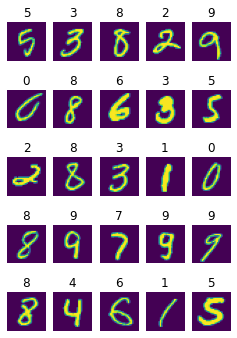

In [ ]:
#Plotting#
figure = plt.figure(figsize=(4, 6))
for i in range(25):
  plt.subplot(5, 5, i + 1)
  plt.axis('off')
  plt.title(sampleY.numpy()[i])
  plt.imshow(sampleX.numpy()[i].squeeze())

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.maxPolling = nn.MaxPool2d(kernel_size=2, stride=2)
    self.linear1 = nn.Linear(in_features=64 * 7 * 7, out_features=128)
    self.linear2 = nn.Linear(in_features=128, out_features=10)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout()

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.maxPolling(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.maxPolling(x)
    x = x.reshape(x.size(0), -1)
    x = self.linear1(x)
    x = self.relu(x)
    x = self.dropout(x)

    pred = self.linear2(x)

    return pred
        

In [ ]:
model = Model()
model.cuda()

Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxPolling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=3136, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
epochs = 10
learning_rate = 1e-2
log_interval = 10
momentum = 0.5

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
def train(model, epochs):
  for epoch in range(epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      data = data.cuda()
      target = target.cuda()

      optimizer.zero_grad()

      outputs = model(data)

      loss = criterion(outputs, target)

      loss.backward()
      optimizer.step()
      if (batch_idx % log_interval == 0):
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
train(model, epochs)

In [ ]:
torch.save(model.state_dict(), 'model.pth')
torch.save(optimizer.state_dict(), 'optimizer.pth')

In [ ]:
def test(model):
  model.eval()
  total_val_loss = 0
  total = 0
  for itr, (image, label) in enumerate(test_loader):
      image = image.cuda()
      label = label.cuda()
      pred = model(image)
      loss = criterion(pred, label)
      total_val_loss += loss.item()

      pred = torch.nn.functional.softmax(pred, dim=1)
      for i, p in enumerate(pred):
          if label[i] == torch.max(p.data, 0)[1]:
              total = total + 1

  accuracy = total / len(test_loader.dataset)

  total_val_loss = total_val_loss / (itr + 1)
  print('Total loss : {:.6f}\t Accuracy: {:.4f}%'.format(total_val_loss, accuracy * 100))

In [ ]:
test(model)

Total loss : 0.029801	 Accuracy: 99.0600%


In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
model.load_state_dict(torch.load('model.pth'))
model.eval()